In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [2]:
import os
from pathlib import Path
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fun_eda

Clustering para las rutas obtenidas con change point detection (CPD).
1. Clusters por agebs
2. Clusters por ruta

#### 1. Carga de la información

In [3]:
##### Load datos demograficos por AGEB
DATOS_DEM_AGEB = "~/bj/data/rutas_tiles/demograficos_agebs_2020-09-15.csv"
ageb_data = pd.read_csv(DATOS_DEM_AGEB) 
#ageb_data['ageb'] = ageb_data['CVE_AGEB'].astype('str').str.zfill(4)
#ageb_data['coord'] = ageb_data['long'].astype(str) + ' ' + ageb_data['lat'].astype(str)
print("Info demografica por AGEB:", ageb_data.shape)
#ageb_data.head(5)

##### Load datos de unidades economicas y rezago social por ageb
DATOS_UE_AGEB = "~/bj/data/table_3_por_ageb.pkl"
ageb_dataUE = pd.read_pickle(DATOS_UE_AGEB) 
ageb_dataUE.drop(columns=['cve_ent', 'entidad', 'cve_mun', 'municipio','cve_loc', 'localidad', 'Clave_de_AGEB' ], inplace=True)
#ageb_dataUE.drop_duplicates(keep='first', inplace=True)
print("Info UE y rezago por AGEB:", ageb_dataUE.shape)


Info demografica por AGEB: (471, 192)
Info UE y rezago por AGEB: (7409, 24)


In [4]:
# data UE

cols = ageb_dataUE.columns[~ageb_dataUE.columns.isin(['ageb_long', 'ageb','ageb_9_dig' , 'Rango_de_pobreza_(%)', 'Rango_de_pobreza_extrema_(%)'])]
ageb_dataUE.rename(columns =  dict(zip(cols, cols + '_ue')), inplace=True)

ageb_dataUE.insert(22,'ue_totales', ageb_dataUE.iloc[:,1:20].sum(axis='columns'))

print(ageb_dataUE.shape)
ageb_dataUE.head(5)

(7409, 25)


,ageb_long,ageb,ageb_9_dig,"Agricultura,_cria_y_explotacion_de_animales,_aprovechamiento_forestal,_pesca_y_caza_ue",Comercio_al_por_mayor_ue,Comercio_al_por_menor_ue,Construccion_ue,Corporativos_ue,"Generacion,_transmision,_distribucion_y_comercializacion_de_energia_electrica,_suministro_de_agua_y_de_gas_natural_por_ductos_al_consumidor_final_ue",Industrias_manufactureras_ue,...,"Servicios_de_esparcimiento_culturales_y_deportivos,_y_otros_servicios_recreativos_ue",Servicios_de_salud_y_de_asistencia_social_ue,Servicios_educativos_ue,Servicios_financieros_y_de_seguros_ue,Servicios_inmobiliarios_y_de_alquiler_de_bienes_muebles_e_intangibles_ue,"Servicios_profesionales,_cientificos_y_tecnicos_ue","Transportes,_correos_y_almacenamiento_ue",ue_totales,Rango_de_pobreza_(%),Rango_de_pobreza_extrema_(%)
0,0900200010010,0010,090020010,0,2,68,0,0,0,14,...,4,14,5,1,1,5,0,163,"(18, 34]","[ 0, 20]"
1,0900200010025,0025,090020025,0,0,37,0,0,0,1,...,1,2,3,0,1,0,0,67,"[ 0, 18]","[ 0, 20]"
2,090020001003A,003A,09002003A,0,0,43,0,0,0,2,...,0,10,3,0,1,2,1,88,"[ 0, 18]","[ 0, 20]"
3,0900200010044,0044,090020044,0,0,45,2,0,0,4,...,1,8,7,0,0,2,0,93,"[ 0, 18]","[ 0, 20]"
4,0900200010097,0097,090020097,0,1,29,0,0,0,4,...,0,9,5,3,1,1,0,80,"[ 0, 18]","[ 0, 20]"


#### 2. Transformación de variables

Todas las variables demográficas seleccionadas y las referentes a las unidades economicas, se convierten a tasas por cada 10,000 habitantes.
Las variables de Rezago Social que se tienen originalmente en intervalos de porcentajes, se convierten a porcentajes, tomado el punto medio del intervalo.

In [5]:
# ageb_data

pob = ['POBMAS', 'POBFEM', 'PRES2005', 'PHOG_IND','PCON_LIM', 'PEA', 'POCUPADA',
 'PDER_SS', 'P12YM_SOLT','P12YM_CASA', 'P12YM_SEPA']
viviendas =['TVIVHAB','TVIVPAR', 'VPH_PISODT', 'VPH_PISOTI', 'VPH_1DOR', 'VPH_2YMASD',
 'VPH_1CUART', 'VPH_2CUART', 'VPH_3YMASC', 'VPH_C_ELEC', 'VPH_AGUADV', 'VPH_AGUAFV', 'VPH_EXCSA', 'VPH_DRENAJ', 'VPH_NODREN',
 'VPH_C_SERV', 'VPH_SNBIEN', 'VPH_RADIO', 'VPH_TV', 'VPH_REFRI', 'VPH_LAVAD', 'VPH_AUTOM', 'VPH_PC', 'VPH_TELEF', 'VPH_CEL',
            'VPH_INTER']

# tasa por 10,000 habs
NHABS = 10000

ageb_data = ageb_data[['id_ageb_ent','POBTOT', 'VIVTOT' ] + pob + viviendas].copy()
ageb_data[pob] = (ageb_data[pob]*NHABS).div(ageb_data['POBTOT'], axis=0)
ageb_data[viviendas] = (ageb_data[viviendas]*NHABS).div(ageb_data['VIVTOT'], axis=0)

print(ageb_data.shape)
ageb_data.head(5)

(471, 40)


,id_ageb_ent,POBTOT,VIVTOT,POBMAS,POBFEM,PRES2005,PHOG_IND,PCON_LIM,PEA,POCUPADA,...,VPH_SNBIEN,VPH_RADIO,VPH_TV,VPH_REFRI,VPH_LAVAD,VPH_AUTOM,VPH_PC,VPH_TELEF,VPH_CEL,VPH_INTER
0,090074698,7230,1728,4840.940526,5159.059474,8633.471646,630.705394,376.210235,4165.975104,3952.973721,...,150.462963,7870.370370,8738.425926,6527.777778,5023.148148,1481.481481,1863.425926,4259.259259,5821.759259,1168.981481
1,090170140,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,090052165,2116,514,4914.933837,5018.903592,8506.616257,160.680529,954.631380,4754.253308,4508.506616,...,0.000000,9105.058366,9649.805447,8910.505837,7743.190661,4591.439689,4221.789883,7334.630350,7003.891051,2704.280156
3,090051928,10,2,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,150990226,6126,1318,4893.894874,5106.105126,8716.944172,6784.198498,349.330722,3653.281097,3578.191316,...,265.553869,7116.843703,8421.851290,4066.767830,3042.488619,3770.864947,880.121396,2625.189681,4195.751138,402.124431


In [6]:
## Join info por AGEB
ageb_data = ageb_data.merge(ageb_dataUE, left_on='id_ageb_ent', right_on='ageb_9_dig',  how='left')
print(ageb_data.shape)
ageb_data.head(5)

(471, 65)


,id_ageb_ent,POBTOT,VIVTOT,POBMAS,POBFEM,PRES2005,PHOG_IND,PCON_LIM,PEA,POCUPADA,...,"Servicios_de_esparcimiento_culturales_y_deportivos,_y_otros_servicios_recreativos_ue",Servicios_de_salud_y_de_asistencia_social_ue,Servicios_educativos_ue,Servicios_financieros_y_de_seguros_ue,Servicios_inmobiliarios_y_de_alquiler_de_bienes_muebles_e_intangibles_ue,"Servicios_profesionales,_cientificos_y_tecnicos_ue","Transportes,_correos_y_almacenamiento_ue",ue_totales,Rango_de_pobreza_(%),Rango_de_pobreza_extrema_(%)
0,090074698,7230,1728,4840.940526,5159.059474,8633.471646,630.705394,376.210235,4165.975104,3952.973721,...,1.0,0.0,1.0,13.0,1.0,0.0,1.0,87.0,"(50, 70]","[ 0, 20]"
1,090170140,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,3.0,227.0,26.0,8.0,85.0,621.0,Sin viviendas particulares habitadas,Sin viviendas particulares habitadas
2,090052165,2116,514,4914.933837,5018.903592,8506.616257,160.680529,954.631380,4754.253308,4508.506616,...,9.0,3.0,9.0,8.0,1.0,2.0,2.0,130.0,Una vivienda particular habitada,Una vivienda particular habitada
3,090051928,10,2,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,4.0,0.0,0.0,0.0,0.0,0.0,7.0,Sin viviendas particulares habitadas,Sin viviendas particulares habitadas
4,150990226,6126,1318,4893.894874,5106.105126,8716.944172,6784.198498,349.330722,3653.281097,3578.191316,...,2.0,6.0,6.0,0.0,0.0,1.0,0.0,252.0,Sin viviendas particulares habitadas,Sin viviendas particulares habitadas


In [7]:
# tasa de unidades economicas por 10,000 habs
cols = ageb_dataUE.columns[ageb_dataUE.columns.str.endswith('_ue')].to_list() + ['ue_totales']
ageb_data[cols] = (ageb_data[cols]*NHABS).div(ageb_data['POBTOT'], axis=0)

# Convertimos a valores numericos (%)
ageb_data['Rango_de_pobreza_(%)'] = ageb_data['Rango_de_pobreza_(%)'].map({'[ 0, 18]':9, '(18, 34]':26, '(34, 50]':44 , '(50, 70]':60, '(70, 100]':85, 'Una vivienda particular habitada':0, 'Sin viviendas particulares habitadas':0}, na_action='ignore')
ageb_data['Rango_de_pobreza_extrema_(%)'] = ageb_data['Rango_de_pobreza_extrema_(%)'].map({'[ 0, 20]':10, '(20, 50]':35, 'Una vivienda particular habitada':0, 'Sin viviendas particulares habitadas':0,}, na_action=0)

ageb_data.drop(columns=['POBTOT', 'VIVTOT'], inplace=True)
print(ageb_data.shape)
ageb_data.head(5)

(471, 63)


,id_ageb_ent,POBMAS,POBFEM,PRES2005,PHOG_IND,PCON_LIM,PEA,POCUPADA,PDER_SS,P12YM_SOLT,...,"Servicios_de_esparcimiento_culturales_y_deportivos,_y_otros_servicios_recreativos_ue",Servicios_de_salud_y_de_asistencia_social_ue,Servicios_educativos_ue,Servicios_financieros_y_de_seguros_ue,Servicios_inmobiliarios_y_de_alquiler_de_bienes_muebles_e_intangibles_ue,"Servicios_profesionales,_cientificos_y_tecnicos_ue","Transportes,_correos_y_almacenamiento_ue",ue_totales,Rango_de_pobreza_(%),Rango_de_pobreza_extrema_(%)
0,090074698,4840.940526,5159.059474,8633.471646,630.705394,376.210235,4165.975104,3952.973721,4846.473029,2868.603043,...,1.383126,0.000000,1.383126,17.980636,1.383126,0.000000,1.383126,120.33195,60.0,10.0
1,090170140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,inf,inf,inf,inf,inf,inf,0.0,0.0
2,090052165,4914.933837,5018.903592,8506.616257,160.680529,954.631380,4754.253308,4508.506616,6096.408318,2958.412098,...,42.533081,14.177694,42.533081,37.807183,4.725898,9.451796,9.451796,614.36673,0.0,0.0
3,090051928,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1000.000000,4000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7000.00000,0.0,0.0
4,150990226,4893.894874,5106.105126,8716.944172,6784.198498,349.330722,3653.281097,3578.191316,2879.529873,2605.288932,...,3.264773,9.794319,9.794319,0.000000,0.000000,1.632387,0.000000,411.36141,0.0,0.0


In [8]:
agebs = ageb_data['id_ageb_ent']
ageb_data.drop(columns=['id_ageb_ent', 'ageb_long', 'ageb', 'ageb_9_dig'], inplace=True)
ageb_data

,POBMAS,POBFEM,PRES2005,PHOG_IND,PCON_LIM,PEA,POCUPADA,PDER_SS,P12YM_SOLT,P12YM_CASA,...,"Servicios_de_esparcimiento_culturales_y_deportivos,_y_otros_servicios_recreativos_ue",Servicios_de_salud_y_de_asistencia_social_ue,Servicios_educativos_ue,Servicios_financieros_y_de_seguros_ue,Servicios_inmobiliarios_y_de_alquiler_de_bienes_muebles_e_intangibles_ue,"Servicios_profesionales,_cientificos_y_tecnicos_ue","Transportes,_correos_y_almacenamiento_ue",ue_totales,Rango_de_pobreza_(%),Rango_de_pobreza_extrema_(%)
0,4840.940526,5159.059474,8633.471646,630.705394,376.210235,4165.975104,3952.973721,4846.473029,2868.603043,3778.699862,...,1.383126,0.000000,1.383126,17.980636,1.383126,0.000000,1.383126,1.203320e+02,60.0,10.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,inf,inf,inf,inf,inf,inf,0.0,0.0
2,4914.933837,5018.903592,8506.616257,160.680529,954.631380,4754.253308,4508.506616,6096.408318,2958.412098,4196.597353,...,42.533081,14.177694,42.533081,37.807183,4.725898,9.451796,9.451796,6.143667e+02,0.0,0.0
3,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1000.000000,4000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000e+03,0.0,0.0
4,4893.894874,5106.105126,8716.944172,6784.198498,349.330722,3653.281097,3578.191316,2879.529873,2605.288932,4237.675482,...,3.264773,9.794319,9.794319,0.000000,0.000000,1.632387,0.000000,4.113614e+02,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,5013.192612,4986.807388,8944.591029,0.000000,237.467018,3773.087071,3746.701847,3878.627968,3034.300792,3825.857520,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.192612,4.485488e+02,0.0,0.0
467,5882.352941,4117.647059,7450.980392,10000.000000,0.000000,4901.960784,4901.960784,0.000000,1372.549020,5882.352941,...,98.039216,490.196078,294.117647,1470.588235,0.000000,98.039216,294.117647,1.205882e+04,44.0,10.0
468,8752.623601,1244.752799,9511.427239,147.213153,178.696362,1294.892724,1256.413246,8945.604011,3499.300373,5500.816231,...,0.874534,0.874534,1.166045,1.457556,0.000000,2.623601,0.000000,5.130597e+01,26.0,10.0
469,4859.550562,5140.449438,9073.033708,351.123596,533.707865,3988.764045,3412.921348,4550.561798,2654.494382,4087.078652,...,0.000000,21.067416,7.022472,7.022472,0.000000,21.067416,0.000000,3.160112e+02,60.0,10.0


In [9]:
# Eliminamos los renglones que se componen solo de NaN o ceros o Inf
del_index = ageb_data[(ageb_data == np.inf).any(axis=1)].index
ageb_data.drop(index=del_index, inplace=True)
agebs.drop(index=del_index, inplace=True)

## Base final
print(ageb_data.shape)
ageb_data.round(2)

(457, 60)


,POBMAS,POBFEM,PRES2005,PHOG_IND,PCON_LIM,PEA,POCUPADA,PDER_SS,P12YM_SOLT,P12YM_CASA,...,Servicios_de_salud_y_de_asistencia_social_ue,Servicios_educativos_ue,Servicios_financieros_y_de_seguros_ue,Servicios_inmobiliarios_y_de_alquiler_de_bienes_muebles_e_intangibles_ue,"Servicios_profesionales,_cientificos_y_tecnicos_ue","Transportes,_correos_y_almacenamiento_ue",ue_totales,Rango_de_pobreza_(%),Rango_de_pobreza_extrema_(%),id_ageb_ent
0,4840.94,5159.06,8633.47,630.71,376.21,4165.98,3952.97,4846.47,2868.60,3778.70,...,0.00,1.38,17.98,1.38,0.00,1.38,120.33,60.0,10.0,090074698
2,4914.93,5018.90,8506.62,160.68,954.63,4754.25,4508.51,6096.41,2958.41,4196.60,...,14.18,42.53,37.81,4.73,9.45,9.45,614.37,0.0,0.0,090052165
3,0.00,3000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,4000.00,0.00,0.00,0.00,0.00,0.00,7000.00,0.0,0.0,090051928
4,4893.89,5106.11,8716.94,6784.20,349.33,3653.28,3578.19,2879.53,2605.29,4237.68,...,9.79,9.79,0.00,0.00,1.63,0.00,411.36,0.0,0.0,150990226
5,4974.59,4864.48,8427.44,191.98,217.39,3608.13,3506.49,4297.01,2284.02,4017.50,...,2.82,5.65,0.00,5.65,5.65,0.00,268.21,85.0,10.0,150590165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,5013.19,4986.81,8944.59,0.00,237.47,3773.09,3746.70,3878.63,3034.30,3825.86,...,0.00,0.00,0.00,0.00,0.00,13.19,448.55,0.0,0.0,150991417
467,5882.35,4117.65,7450.98,10000.00,0.00,4901.96,4901.96,0.00,1372.55,5882.35,...,490.20,294.12,1470.59,0.00,98.04,294.12,12058.82,44.0,10.0,090072121
468,8752.62,1244.75,9511.43,147.21,178.70,1294.89,1256.41,8945.60,3499.30,5500.82,...,0.87,1.17,1.46,0.00,2.62,0.00,51.31,26.0,10.0,090071994
469,4859.55,5140.45,9073.03,351.12,533.71,3988.76,3412.92,4550.56,2654.49,4087.08,...,21.07,7.02,7.02,0.00,21.07,0.00,316.01,60.0,10.0,150920085


In [11]:
ageb_data.drop(columns=['id_ageb_ent'], inplace = True)

In [12]:
ageb_data.rename(columns={'Generacion,_transmision,_distribucion_y_comercializacion_de_energia_electrica,_suministro_de_agua_y_de_gas_natural_por_ductos_al_consumidor_final_ue':'Electricidad_ue',
       'Servicios_de_alojamiento_temporal_y_de_preparacion_de_alimentos_y_bebidas_ue':'Alimentos_y_bebidas_ue',
       'Servicios_de_apoyo_a_los_negocios_y_manejo_de_residuos,_y_servicios_de_remediacion_ue':'Manejo_residuos_ue',
       'Servicios_de_esparcimiento_culturales_y_deportivos,_y_otros_servicios_recreativos_ue':'Esparcimiento_ue',
        'Servicios_inmobiliarios_y_de_alquiler_de_bienes_muebles_e_intangibles_ue':'Inmobiliarios_y_bienes_muebles_ue'}, inplace=True)

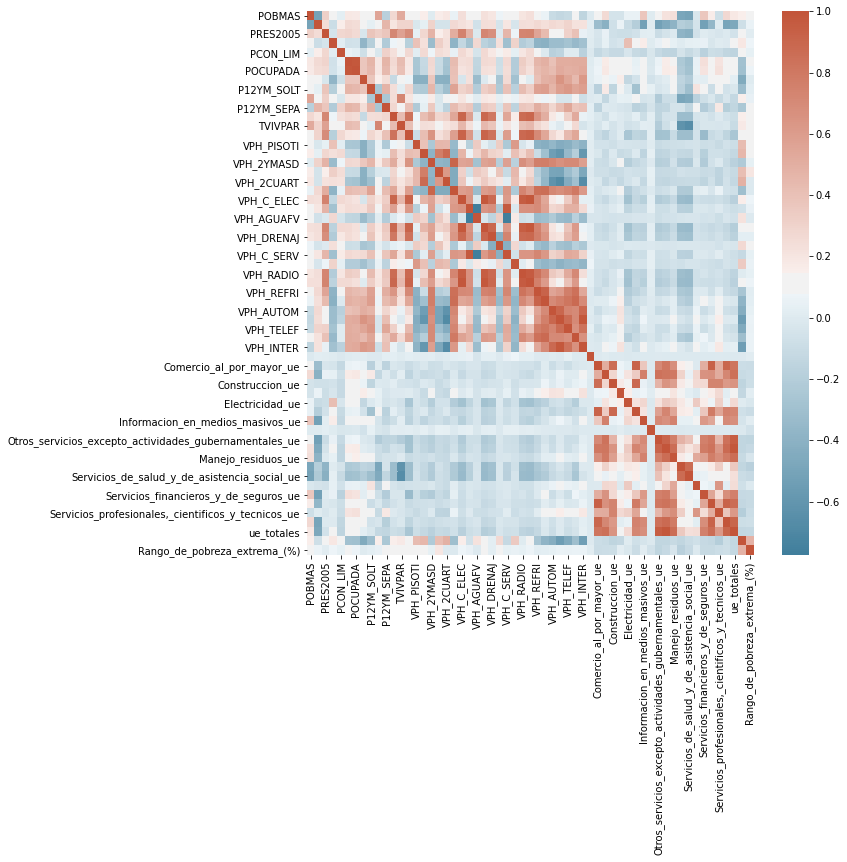

In [13]:
plt.figure(figsize=(10,10))
corr_matrix = ageb_data.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, annot=False, cmap=cmap)

In [14]:
pd.set_option('display.max_columns', 210)
fun_eda.descriptive_stats_for_numeric_vars(ageb_data, ageb_data.columns)

,POBMAS,POBFEM,PRES2005,PHOG_IND,PCON_LIM,PEA,POCUPADA,PDER_SS,P12YM_SOLT,P12YM_CASA,P12YM_SEPA,TVIVHAB,TVIVPAR,VPH_PISODT,VPH_PISOTI,VPH_1DOR,VPH_2YMASD,VPH_1CUART,VPH_2CUART,VPH_3YMASC,VPH_C_ELEC,VPH_AGUADV,VPH_AGUAFV,VPH_EXCSA,VPH_DRENAJ,VPH_NODREN,VPH_C_SERV,VPH_SNBIEN,VPH_RADIO,VPH_TV,VPH_REFRI,VPH_LAVAD,VPH_AUTOM,VPH_PC,VPH_TELEF,VPH_CEL,VPH_INTER,"Agricultura,_cria_y_explotacion_de_animales,_aprovechamiento_forestal,_pesca_y_caza_ue",Comercio_al_por_mayor_ue,Comercio_al_por_menor_ue,Construccion_ue,Corporativos_ue,Electricidad_ue,Industrias_manufactureras_ue,Informacion_en_medios_masivos_ue,Mineria_ue,Otros_servicios_excepto_actividades_gubernamentales_ue,Alimentos_y_bebidas_ue,Manejo_residuos_ue,Esparcimiento_ue,Servicios_de_salud_y_de_asistencia_social_ue,Servicios_educativos_ue,Servicios_financieros_y_de_seguros_ue,Inmobiliarios_y_bienes_muebles_ue,"Servicios_profesionales,_cientificos_y_tecnicos_ue","Transportes,_correos_y_almacenamiento_ue",ue_totales,Rango_de_pobreza_(%),Rango_de_pobreza_extrema_(%)
n_observations,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,448.000000,448.000000
max,8752.623601,5858.585859,9511.427239,10000.000000,1125.000000,7755.690003,7703.831749,10000.000000,4839.285714,5882.352941,1778.656126,5000.000000,5000.000000,10000.000000,2338.926174,6060.606061,8961.538462,4285.714286,4163.133229,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,8787.878788,10000.000000,367.585631,10000.000000,10000.000000,10000.000000,10000.000000,8905.109489,8540.145985,8692.893401,10000.000000,8195.187166,1.353913,7857.142857,13333.333333,178.571429,22.123894,98.039216,9464.285714,833.333333,16.782278,2083.333333,6607.142857,833.333333,1000.000000,4000.000000,2446.428571,6153.846154,535.714286,428.571429,2916.666667,33571.428571,85.000000,35.000000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.070310,0.000000,0.000000
mean,4857.955783,5072.058366,8319.725512,433.832049,333.021023,4170.428861,3982.821014,5646.614194,2669.242095,4184.752653,712.082007,4257.904974,4889.354059,7942.980368,200.194842,2837.281775,5328.802887,572.409709,1298.115537,6230.263685,8222.052252,7486.071464,709.766062,8127.510441,8011.662536,186.768063,7333.701711,23.972411,7404.897314,8047.169072,6900.278893,5885.183763,3655.079969,3016.864569,4576.997074,5987.305767,2249.949004,0.011394,40.934192,223.395580,1.367396,0.175830,1.373728,60.728256,4.013958,0.082898,55.424287,101.660990,11.175248,9.724670,21.024573,15.255632,51.056799,6.613435,7.796499,17.683507,604.018866,37.366071,9.397321
std_dev,444.198032,445.435106,947.063514,742.604151,184.166743,587.497203,578.634614,1293.101609,451.583088,411.890109,256.677070,605.807023,349.669843,1347.569257,284.799600,1203.150483,1271.878637,537.736291,791.293213,1384.669704,1294.426807,2058.002189,1570.430885,1289.808945,1435.765450,663.384664,2094.517242,39.645834,1189.326082,1261.169172,1388.646786,1363.041329,1548.114403,1817.999025,1922.683176,

In [15]:
# fill NaN
ageb_data = ageb_data.fillna(0)

# Fill Inf
#cols =  ageb_data.columns[ageb_data.columns.str.endswith('_ue')]
#for col in cols:
#    ageb_data.loc[ageb_data[col] == np.inf, col]=0

#ageb_data.loc[ageb_data['ue_totales'] == np.inf, 'ue_totales']=0

#### 3. Escalamiento de las variables numéricas

In [16]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

import math
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from itertools import product

In [17]:
# scale numeric variables
scaler = StandardScaler()
ageb_data_scaled = scaler.fit_transform(ageb_data)

#### 4. DBScan

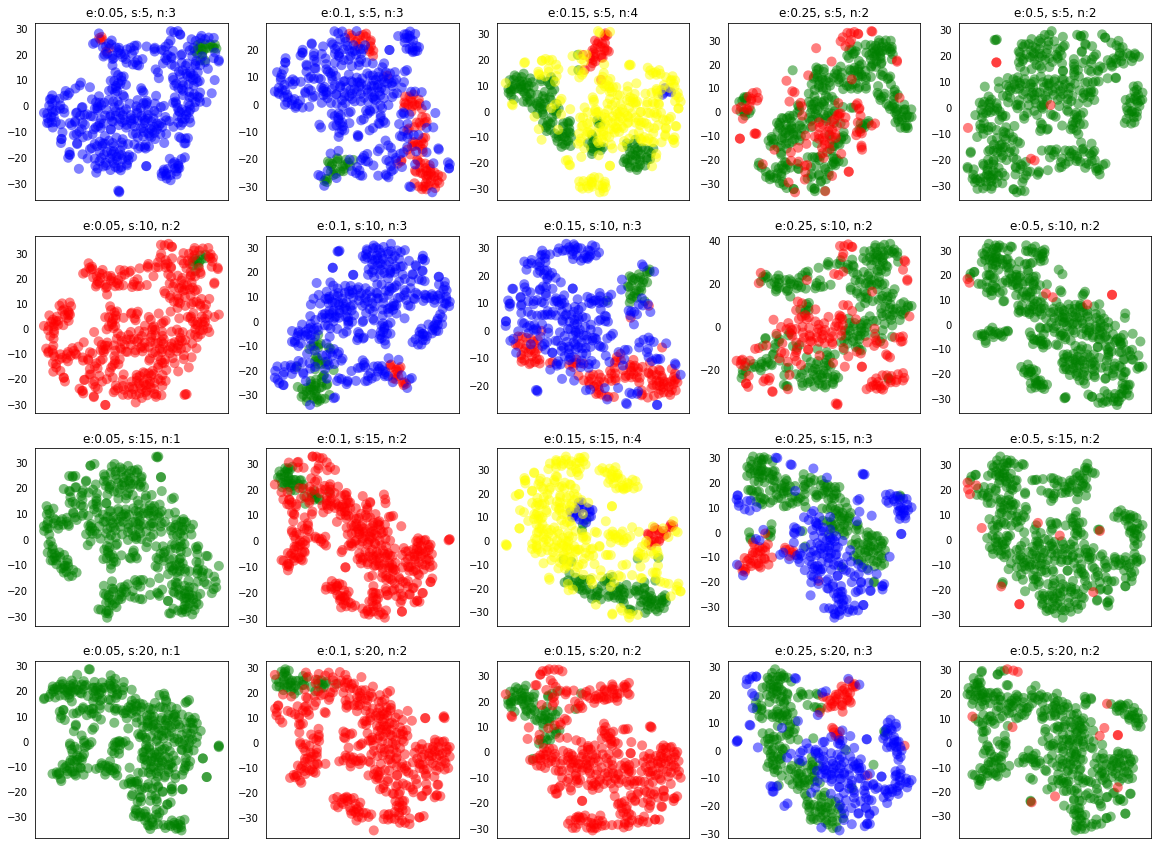

In [36]:
samp_list = [5, 10, 15, 20]
eps_list = [0.05, 0.10, 0.15, 0.25, 0.5]
nrows = len(samp_list)
# Perplexity (tsne)
per = 20

fig, ax = plt.subplots(len(samp_list), len(eps_list), figsize = (20,15))

for k, (eps, samp) in enumerate(product(eps_list, samp_list)):
    ax[k%nrows][math.floor(k/nrows)].tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False)
    
    # Calculo los clusters
    clustering = DBSCAN(eps=eps, min_samples=samp, metric='cosine').fit(ageb_data_scaled)
        
    # Visualizacion
    tsne = TSNE(n_components=2, perplexity= per)
    tsne_components = tsne.fit_transform(ageb_data_scaled)
    TSNE_df = pd.DataFrame(tsne_components)
    TSNE_df.insert(0, 'cluster', clustering.labels_)
    
    datas = [[TSNE_df[TSNE_df['cluster']==i][j] for j in range(2)] for i in list(set(clustering.labels_))]
    colors =  ('green', 'red', 'blue', 'yellow', 'purple')
    groups = [str(i) for i in list(set(clustering.labels_))]
       
    for data, group, color in zip(datas, groups, colors):
        #print(len(data), len(color), len(group))
        # cmap=plt.get_cmap('viridis')
        ax[k%nrows][math.floor(k/nrows)].scatter(data[0], data[1], alpha=0.5, c=color, edgecolors='none', s=100, label=group)
        ax[k%nrows][math.floor(k/nrows)].set_title(f'e:{eps}, s:{samp}, n:{len(groups)}')
    

##### 4.1 Seleccion de parametros

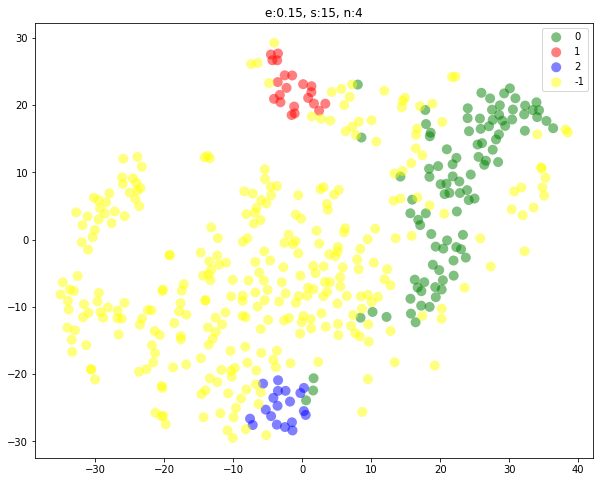

In [39]:
eps = 0.15
samp = 15

# per =70, eps = 0.15, samp=15
# per = 20, eps = 0.15, samp=15


fig, ax = plt.subplots(1,1, figsize = (10,8))

# Calculo los clusters
clustering = DBSCAN(eps=eps, min_samples=samp, metric='cosine').fit(ageb_data_scaled)
        
# Visualizacion
tsne = TSNE(n_components=2, perplexity= per)
tsne_components = tsne.fit_transform(ageb_data_scaled)
TSNE_df = pd.DataFrame(tsne_components)
TSNE_df.insert(0, 'cluster', clustering.labels_)
    
n=len(set(clustering.labels_))
datas = [[TSNE_df[TSNE_df['cluster']==i][j] for j in range(2)] for i in list(set(clustering.labels_))]
colors =  ('green', 'red', 'blue', 'yellow', 'purple')
groups = [str(i) for i in list(set(clustering.labels_))]
       
for data, group, color in zip(datas, groups, colors):
    #print(len(data), len(color), len(group))
    # cmap=plt.get_cmap('viridis')
    ax.scatter(data[0], data[1], alpha=0.5, c=color, edgecolors='none', s=100, label=group)
    ax.set_title(f'e:{eps}, s:{samp}, n:{len(groups)}')
    ax.legend()


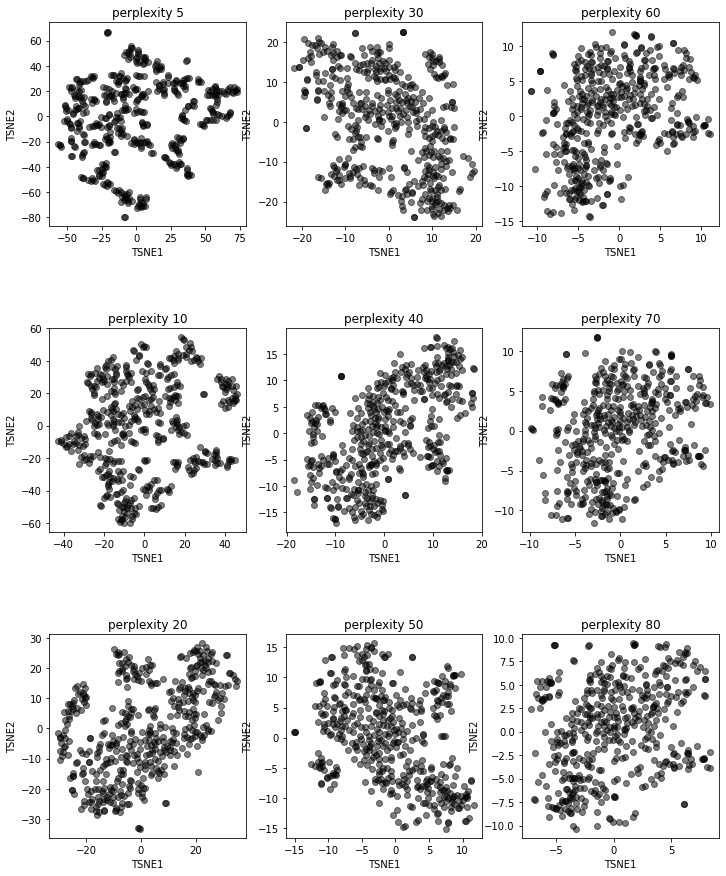

In [19]:
fig, ax = plt.subplots(3,3,figsize=(12,15))
plt.subplots_adjust(hspace=0.5)

perplexity = [5, 10, 20, 30, 40, 50, 60, 70, 80]
for i, per in enumerate(perplexity):
    tsne = TSNE(n_components=2, perplexity= per)
    tsne_components = tsne.fit_transform(ageb_data_scaled)
    TSNE_components = pd.DataFrame(tsne_components, index=agebs)
    
    ax[i%3][math.floor(i/3)].set_title(f'perplexity {per}')
    ax[i%3][math.floor(i/3)].scatter(TSNE_components[0], TSNE_components[1], alpha=0.5, color='black')
    ax[i%3][math.floor(i/3)].set(xlabel='TSNE1')
    ax[i%3][math.floor(i/3)].set(ylabel='TSNE2')

#### 5. K-means

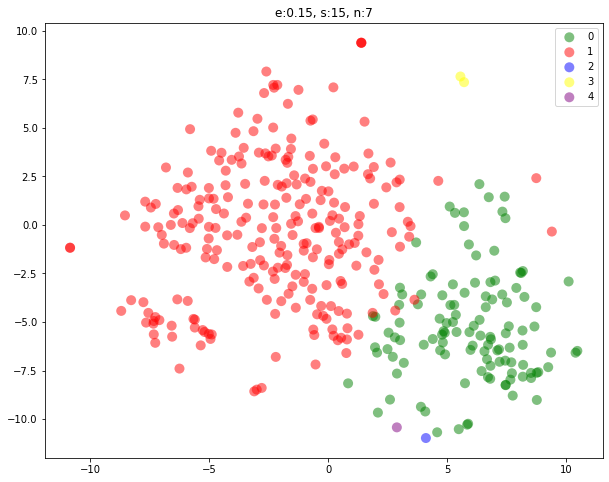

In [66]:
per=70
#Initialize our model
kmeans = KMeans(n_clusters=7)
#Fit our model
kmeans.fit(ageb_data_scaled)
#Find which cluster each data-point belongs to
kmeans_clusters = kmeans.predict(ageb_data_scaled)

fig, ax = plt.subplots(1,1, figsize = (10,8))
# Visualizacion K-means
tsne = TSNE(n_components=2, perplexity= per)
tsne_components = tsne.fit_transform(ageb_data_scaled)
TSNE_df = pd.DataFrame(tsne_components)
TSNE_df.insert(0, 'cluster', kmeans_clusters)
    
n=len(set(clustering.labels_))
datas = [[TSNE_df[TSNE_df['cluster']==i][j] for j in range(2)] for i in list(set(kmeans_clusters))]
colors =  ('green', 'red', 'blue', 'yellow', 'purple')
groups = [str(i) for i in list(set(kmeans_clusters))]
       
for data, group, color in zip(datas, groups, colors):
    #print(len(data), len(color), len(group))
    # cmap=plt.get_cmap('viridis')
    ax.scatter(data[0], data[1], alpha=0.5, c=color, edgecolors='none', s=100, label=group)
    ax.set_title(f'e:{eps}, s:{samp}, n:{len(groups)}')
    ax.legend()
